# Neural Network Project (POUYA IRANI)
Deep neural networks have provided solutions for problems such as denoising, which implicitly rely on a prior probability model of natural images.

In this project a robust and general methodology for making use of this implicit prior is developed.

We develop a stochastic coarse-to-fine gradient ascent procedure for drawing high-probability samples from the implicit prior embedded within a CNN trained to perform blind (i.e., with unknown noise level) least-squares denoising. 

We also develop unsupervised performance for deblurring, super-resolution, inpainting, and compressive sensing.

In [ ]:
# import data from my drive with the following address:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#importing necessary libraries
import numpy as np
import torch.nn as nn
import torch

################################################# network class #################################################

#Defining the neural network classes

class BF_CNN(nn.Module):

    def __init__(self, args):
        super(BF_CNN, self).__init__()

        self.padding = args.padding
        self.num_kernels = args.num_kernels
        self.kernel_size = args.kernel_size
        self.num_layers = args.num_layers
        self.num_channels = args.num_channels

        self.conv_layers = nn.ModuleList([])
        self.running_sd = nn.ParameterList([])
        self.gammas = nn.ParameterList([])


        self.conv_layers.append(nn.Conv2d(self.num_channels,self.num_kernels, self.kernel_size, padding=self.padding , bias=False))

        for l in range(1,self.num_layers-1):
            self.conv_layers.append(nn.Conv2d(self.num_kernels ,self.num_kernels, self.kernel_size, padding=self.padding , bias=False))
            self.running_sd.append( nn.Parameter(torch.ones(1,self.num_kernels,1,1), requires_grad=False) )
            g = (torch.randn( (1,self.num_kernels,1,1) )*(2./9./64.)).clamp_(-0.025,0.025)
            self.gammas.append(nn.Parameter(g, requires_grad=True) )

        self.conv_layers.append(nn.Conv2d(self.num_kernels,self.num_channels, self.kernel_size, padding=self.padding , bias=False))


    def forward(self, x):
        relu = nn.ReLU(inplace=True)
        x = relu(self.conv_layers[0](x))
        for l in range(1,self.num_layers-1):
            x = self.conv_layers[l](x)
            # BF_BatchNorm
            sd_x = torch.sqrt(x.var(dim=(0,2,3) ,keepdim = True, unbiased=False)+ 1e-5)

            if self.conv_layers[l].training:
                x = x / sd_x.expand_as(x)
                self.running_sd[l-1].data = (1-.1) * self.running_sd[l-1].data + .1 * sd_x
                x = x * self.gammas[l-1].expand_as(x)

            else:
                x = x / self.running_sd[l-1].expand_as(x)
                x = x * self.gammas[l-1].expand_as(x)

            x = relu(x)

        x = self.conv_layers[-1](x)

        return x

In [ ]:
#importing necessary libraries
import numpy as np
import torch
import matplotlib
matplotlib.use('Agg')
import matplotlib.pylab as plt
import torch.nn as nn
import os
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import torch.fft
import gzip
import argparse
################################################# Helper Functions #################################################

def load_denoiser(architecture,grayscale, training_data, training_noise): 
    if architecture=='BF_CNN': 
        model = load_BF_CNN(grayscale, training_data, training_noise)

        
    return model

def load_BF_CNN(grayscale, training_data, training_noise): 
    '''
    @ grayscale: if True, number of input and output channels are set to 1. Otherwise 3
    @ training_data: models provided in here have been trained on {BSD400, mnist, BSD300}
    @ training_noise: standard deviation of noise during training the denoiser
    '''
    #########################################
    #help
    parser = argparse.ArgumentParser(description='BF_CNN_color')
    parser.add_argument('--dir_name', default= '../noise_range_')
    parser.add_argument('--kernel_size', default= 3)
    parser.add_argument('--padding', default= 1)
    parser.add_argument('--num_kernels', default= 64)
    parser.add_argument('--num_layers', default= 20)
    if grayscale is True: 
        parser.add_argument('--num_channels', default= 1)
    else:
        parser.add_argument('--num_channels', default= 3)
    
    args = parser.parse_args('')

    model = BF_CNN(args)
    if torch.cuda.is_available():
        model = model.cuda()
    model_path = os.path.join('denoisers/BF_CNN',training_data,training_noise,'model.pt')
    if torch.cuda.is_available():
        learned_params =torch.load(model_path)

    else:
        learned_params =torch.load(model_path, map_location='cpu' )
    model.load_state_dict(learned_params)
    return model

#################################################
def single_image_loader(data_set_dire_path, image_number):
    
    if 'mnist' in data_set_dire_path.split('/'): 
        f = gzip.open(data_set_dire_path + '/t10k-images-idx3-ubyte.gz','r')
        f.read(16)
        buf = f.read(28 * 28 *10000)
        data = np.frombuffer(buf, dtype=np.uint8).astype(float)/255
        x = torch.tensor(data.reshape( 10000,28, 28).astype('float32'))[image_number:image_number+1]
        
    else: 
        all_names = os.listdir(data_set_dire_path)
        file_name = all_names[image_number]
        im = plt.imread(data_set_dire_path + file_name)
        if len(im.shape) == 3:
            x = torch.tensor(im).permute(2,0,1)
        elif len(im.shape) == 2:
            x = torch.tensor(im.reshape(1, im.shape[0], im.shape[1]))
            
    return x

class test_image: 
    def __init__(self, grayscale,path, image_num):
        super(test_image, self).__init__()
        
        self.grayscale = grayscale
        self.path = path
        self.image_num = image_num
        
        self.im = single_image_loader(self.path,self.image_num)
        if self.im.dtype == torch.uint8: 
            self.im = self.im/255
        if self.im.size()[0] == 3 and grayscale==True: 
            raise Exception('model is trained for grayscale images. Load a grayscale image')
        elif self.im.size()[0] == 1 and grayscale==False: 
            raise Exception('model is trained for color images. Load a color image')
        if torch.cuda.is_available():
            self.im = self.im.cuda()
        
    def show(self):
        if self.grayscale is True: 
            if torch.cuda.is_available():
                plt.imshow(self.im.squeeze(0).cpu(), 'gray', vmin=0, vmax = 1)
            else: 
                plt.imshow(self.im.squeeze(0), 'gray', vmin=0, vmax = 1)                
        else: 
            if torch.cuda.is_available():
                plt.imshow(self.im.permute(1,2,0).cpu(), vmin=0, vmax = 1)
            else: 
                plt.imshow(self.im.permute(1,2,0), vmin=0, vmax = 1)

        plt.title('test image')
        plt.colorbar()
#         plt.axis('off');

    def crop(self, x0,y0,h,w):
        self.cropped_im = self.im[:, x0:x0+h, y0:y0+w]             
        if self.grayscale is True: 
            if torch.cuda.is_available():
                plt.imshow(self.cropped_im.squeeze(0).cpu(), 'gray', vmin=0, vmax = 1)
            else: 
                plt.imshow(self.cropped_im.squeeze(0), 'gray', vmin=0, vmax = 1)
                
        else: 
            if torch.cuda.is_available():            
                plt.imshow(self.cropped_im.permute(1,2,0).cpu(), vmin=0, vmax = 1)
            else: 
                plt.imshow(self.cropped_im.permute(1,2,0), vmin=0, vmax = 1)

        plt.title('cropped test image')
        plt.colorbar()
#         plt.axis('off');        
        return self.cropped_im


#################################################
def rescale_image(im):
    if type(im) == torch.Tensor: 
        im = im.numpy()
    return ((im - im.min()) * (1/(im.max() - im.min()) * 255)).astype('uint8')


def plot_synthesis(intermed_Ys, sample):
    f, axs = plt.subplots(1,len(intermed_Ys), figsize = ( 4*len(intermed_Ys),4))
    axs = axs.ravel()

    #### plot intermediate steps
    for ax in range(len(intermed_Ys)):
        if torch.cuda.is_available():
            intermed_Ys[ax] = intermed_Ys[ax].cpu()
            
        x = intermed_Ys[ax].permute(1,2,0).detach().numpy() 
        if x.shape[2] == 1: # if grayscale
            fig = axs[ax].imshow(x.squeeze(-1), 'gray')
        else: # if color
            fig = axs[ax].imshow(rescale_image(x))
        axs[ax].axis('off')

    #### plot final sample
    if torch.cuda.is_available():
        sample =sample.cpu()
        
    sample = sample.permute(1,2,0).detach().numpy()
    if sample.shape[2] == 1: # if grayscale
        fig = axs[-1].imshow(sample.squeeze(-1),'gray' )
    else: # if color
        fig = axs[-1].imshow(rescale_image(sample))

    axs[-1].axis('off')
    print('value range', np.round(np.min(sample ),2), np.round(np.max(sample),2) )


def plot_sample(x, corrupted, sample):
    if torch.cuda.is_available():
        x = x.cpu()
        corrupted = corrupted.cpu()
        sample = sample.cpu()
        
    x = x.permute(1,2,0)
    corrupted = corrupted.permute(1,2,0)
    sample = sample.detach().permute(1,2,0)
        
    if x.size()!=corrupted.size():    
        h_diff = x.size()[0] - corrupted.size()[0]
        w_diff = x.size()[1] - corrupted.size()[1]
        x = x[0:x.size()[0]-h_diff,0:x.size()[1]-w_diff,: ]
        print('NOTE: psnr and ssim calculated using a cropped original image, because the original image is not divisible by the downsampling scale factor.')
        
    f, axs = plt.subplots(1,3, figsize = (15,5))
    axs = axs.ravel()        
    if x.shape[2] == 1: # if gray scale image
        fig = axs[0].imshow( x.squeeze(-1), 'gray', vmin=0, vmax = 1)
        axs[0].set_title('original')
        
        fig = axs[1].imshow(corrupted.squeeze(-1), 'gray',vmin=0, vmax = 1)
        ssim = np.round(structural_similarity(x.squeeze(-1).numpy(), corrupted.squeeze(-1).numpy()  ) ,3 )
        psnr = np.round(peak_signal_noise_ratio(x.numpy(), corrupted.numpy() ),2)
        axs[1].set_title('corrupted image \n psnr: '+str( psnr) + '\n ssim '+ str(ssim) );  
        
        fig = axs[2].imshow(sample.squeeze(-1),'gray' ,vmin=0, vmax = 1)
        ssim = np.round(structural_similarity(x.squeeze(-1).numpy(), sample.squeeze(-1).numpy()  ) ,3 )
        psnr = np.round(peak_signal_noise_ratio(x.numpy(), sample.numpy() ),2)
        axs[2].set_title('reconstructed \n psnr: '+str( psnr) + '\n ssim '+ str(ssim) );

            
    else: # if color image
        fig = axs[0].imshow( x, vmin=0, vmax = 1)
        axs[0].set_title('original')        
        
        fig = axs[1].imshow( torch.clip(corrupted,0,1), vmin=0, vmax = 1)
        ssim = np.round(structural_similarity(x.numpy(), corrupted.numpy(), multichannel=True  ) ,3 )
        psnr = np.round(peak_signal_noise_ratio(x.numpy(), corrupted.numpy() ),2)
        axs[1].set_title('corrupted image \n psnr: '+str( psnr) + '\n ssim '+ str(ssim) );  
        
        fig = axs[2].imshow(torch.clip(sample, 0,1),vmin=0, vmax = 1)
        ssim = np.round(structural_similarity(x.numpy(), sample.numpy() , multichannel=True) ,3)
        psnr = np.round(peak_signal_noise_ratio(x.numpy(), sample.numpy() ),2)   
        axs[2].set_title('reconstructed \n psnr: '+str( psnr) + '\n ssim '+ str(ssim) );
            
            
    for i in range(3): 
        axs[i].axis('off')
    
    


def plot_all_samples(sample, intermed_Ys):
    n_rows = int(np.ceil(len(intermed_Ys)/4))

    f, axs = plt.subplots(n_rows,4, figsize = ( 4*4, n_rows*4))
    axs = axs.ravel()

    #### plot intermediate steps
    for ax in range(len(intermed_Ys)):
        if torch.cuda.is_available():
            intermed_Ys[ax] = intermed_Ys[ax].cpu()
            
        x = intermed_Ys[ax].detach().permute(1,2,0).numpy()
        if x.shape[2] == 1:
            fig = axs[ax].imshow(x.squeeze(-1), 'gray')
        else:
            fig = axs[ax].imshow(rescale_image(x))
        axs[ax].axis('off')
    
    #### plot final sample
    if torch.cuda.is_available():
        sample =sample.cpu()
        
    sample = sample.detach().permute(1,2,0).numpy()
    if sample.shape[2] == 1:
        fig = axs[-1].imshow(sample.squeeze(-1),'gray' )
    else:
        fig = axs[-1].imshow(rescale_image(sample))
    axs[-1].axis('off')
    plt.colorbar(fig, ax=axs[-1], fraction=.05)


    for ax in range(len(intermed_Ys),n_rows*4 ):
        axs[ax].axis('off')


def plot_corrupted_im(x_c): 
    try:

        if torch.cuda.is_available():
            plt.imshow(x_c.squeeze(0).cpu(), 'gray', vmin=0, vmax = 1)
        else: 
            plt.imshow(x_c.squeeze(0), 'gray', vmin=0, vmax = 1)
    except TypeError: 
        if torch.cuda.is_available():
            plt.imshow(x_c.permute(1,2,0).cpu(), vmin=0, vmax = 1)
        else: 
            plt.imshow(x_c.permute(1,2,0) , vmin=0, vmax = 1)

    plt.colorbar()    
    

def print_dim(measurment_dim, image_dim):
    print('*** Retained {} / {} ({}%) of dimensions'.format(int(measurment_dim), image_dim
                                                   , np.round(int(measurment_dim)/int(image_dim)*100,
                                                              decimals=3) ))    
    
###################################### Inverse problems Tasks ##################################
#############################################################################################
class synthesis:
    def __init__(self):
        super(synthesis, self).__init__()

    def M_T(self, x):
        return torch.zeros_like(x)

    def M(self, x):
        return torch.zeros_like(x)

class inpainting:
    '''
    makes a blanked area in the center
    @x_size : image size, tuple of (n_ch, im_d1,im_d2)
    @x0,y0: center of the blanked area
    @w: width of the blanked area
    @h: height of the blanked area
    '''
    def __init__(self, x_size,x0,y0,h, w):
        super(inpainting, self).__init__()

        n_ch , im_d1, im_d2 = x_size
        self.mask = torch.ones(x_size)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
        c1, c2 = int(x0), int(y0)
        h , w= int(h/2), int(w/2)
        self.mask[0:n_ch, c1-h : c1+h , c2-w:c2+w] = 0

    def M_T(self, x):
        return x*self.mask

    def M(self, x):
        return x*self.mask

    
class rand_pixels:
    '''
    @x_size : tuple of (n_ch, im_d1,im_d2)
    @p: fraction of dimensions kept in (0,1)
    '''
    def __init__(self, x_size, p):
        super(rand_pixels, self).__init__()

        self.mask = np.zeros(x_size).flatten()
        self.mask[0:int(p*np.prod(x_size))] = 1
        self.mask = torch.tensor(np.random.choice(self.mask, size = x_size , replace = False).astype('float32').reshape(x_size))
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()        
        
    def M_T(self, x):                                                                                                       
        return x*self.mask

    def M(self, x):
        return x*self.mask

    
class super_resolution:
    '''
    block averaging for super resolution.
    creates a low rank matrix (thin and tall) for down sampling
    @s: downsampling factor, int
    @x_size: tuple of three int  (n_ch, im_d1, im_d2)
    '''

    def __init__(self, x_size, s):
        super(super_resolution, self).__init__()

#         if x_size[1]%2 !=0 or x_size[2]%2 != 0 :
#             raise Exception("image dimensions need to be even")

        self.down_sampling_kernel = torch.ones(x_size[0],1,s,s)
        self.down_sampling_kernel = self.down_sampling_kernel/np.linalg.norm(self.down_sampling_kernel[0,0])
        if torch.cuda.is_available():
            self.down_sampling_kernel = self.down_sampling_kernel.cuda()
        self.x_size = x_size
        self.s = s

    def M_T(self, x):
        down_im = torch.nn.functional.conv2d(x.unsqueeze(0), self.down_sampling_kernel, stride= self.s, groups = self.x_size[0])
        return down_im[0]

    def M(self, x):
        rec_im = torch.nn.functional.conv_transpose2d(x.unsqueeze(0), self.down_sampling_kernel, stride= self.s, groups = self.x_size[0])

        return rec_im[0]


    
class random_basis:
    '''
    @x_size : tuple of (im_d1,im_d2)
    @p: fraction of dimensions kept in (0,1)
    '''
    def __init__(self, x_size, p):
        super(random_basis, self).__init__()
        n_ch , im_d1, im_d2 = x_size
        self.x_size = x_size
        self.U, _ = torch.qr(torch.randn(int(np.prod(x_size)),int(np.prod(x_size)*p) ))
        if torch.cuda.is_available():
            self.U = self.U.cuda()

    def M_T(self, x):
        # gets 2d or 3d image and returns flatten partial measurement(1d)
        return torch.matmul(self.U.T,x.flatten())

    def M(self, x):
        # gets flatten partial measurement (1d), and returns 2d or 3d reconstruction
        return torch.matmul(self.U,x).reshape(self.x_size[0], self.x_size[1], self.x_size[2])


#### important: when using fftn from torch the reconstruction is more lossy than when fft2 from numpy
#### the difference between reconstruction and clean image in pytorch is of order of e-8, but in numpy is e-16

class spectral_super_resolution:
    '''
    creates a mask for dropping high frequency coefficients
    @im_d: dimension of the input image is (im_d, im_d)
    @p: portion of coefficients to keep
    '''
    def __init__(self, x_size, p):
        super(spectral_super_resolution, self).__init__()

        self.x_size = x_size
        
        xf = int(round(x_size[1]*np.sqrt(p) )/2)
        yf = int(round(x_size[1]*x_size[2]*p/xf )/4)
                
        mask = torch.ones((x_size[1],x_size[2]))

        mask[xf:x_size[1]-xf,:]=0
        mask[:, yf:x_size[2]-yf]=0        
        self.mask = mask
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()

    def M_T(self, x):
        # returns fft of each of the three color channels independently
        return self.mask*torch.fft.fftn(x, norm= 'ortho', dim = (1,2),s = (self.x_size[1], self.x_size[2]) )

    def M(self, x):
        return torch.real(torch.fft.ifftn(x, norm= 'ortho',  dim = (1,2), s = (self.x_size[1], self.x_size[2]) ))

# Universal Inverse Problem 

In this project several steps has been covered:

1) A pre-trained denoiser from the "denoisers" directory is loaded; 

2) Sample patches from the image prior embedded in that denoiser is generated; 

3)The embedded prior to solve ("regularize") linear inverse problems is used.



In [ ]:
import numpy as np
import torch
import time
import os



### Takes a tensor of size (n_ch, im_d1, im_d2)
### and returns a tensor of size (n_ch, im_d1, im_d2)
def univ_inv_sol(model, x_c ,task ,sig_0=1, sig_L=.01, h0=.01 , beta=.01 , freq=5):
    '''
    @x_c:  M^T.x)
    @task: the specific linear inverse problem
    @sig_0: initial sigma (largest)
    @sig_L: final sigma (smallest)
    @h0: 1st step size
    @beta:controls added noise in each iteration (0,1]. if 1, no noise is added. As it decreases more noise added.
    '''
    
    M_T = task.M_T #low rank measurement matrix - in function form
    M = task.M #inverse of M_T
    
    n_ch, im_d1,im_d2 = M(x_c).size()
    N = n_ch* im_d1*im_d2
    intermed_Ys=[]

    # initialize y
    e =  torch.ones_like(M(x_c), requires_grad= False )
    y = torch.normal((e - M(M_T(e)))*.5 + M(x_c), sig_0)
    y = y.unsqueeze(0)
    y.requires_grad = False

    if freq > 0:
        intermed_Ys.append(y.squeeze(0))


    if torch.cuda.is_available():
        y = y.cuda()

    f_y = model(y)


    sigma = torch.norm(f_y)/np.sqrt(N)


    t=1
    start_time_total = time.time()
    while sigma > sig_L:


        h = h0*t/(1+ (h0*(t-1)) )
        with torch.no_grad():
            f_y = model(y)

        d = f_y - M(M_T(f_y[0])) + ( M(M_T(y[0]))  - M(x_c) )


        sigma = torch.norm(d)/np.sqrt(N)

        gamma = sigma*np.sqrt(((1 - (beta*h))**2 - (1-h)**2 ))

        noise = torch.randn(n_ch, im_d1,im_d2)

        if torch.cuda.is_available():
            noise = noise.cuda()

        y = y -  h*d + gamma*noise

        if freq > 0 and t%freq== 0:
            print('-----------------------------', t)
            print('sigma ' , sigma.item() )
            intermed_Ys.append(y.squeeze(0))


        t +=1


    print("-------- total number of iterations, " , t )
    print("-------- average time per iteration (s), " , np.round((time.time() - start_time_total)/(t-1)  ,4) )

    denoised_y = y - model(y)


    return denoised_y.squeeze(0), intermed_Ys

In [ ]:
import numpy as np
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import matplotlib.pylab as plt
import os
import time
import torch
import sys
sys.path.insert(0, 'code')

%matplotlib inline

# load a denoiser

Different denoisers embed different priors. In the context of deep neural networks, the learned prior depends on both the network architecture and the training dataset. Changing the architecture and/or the training set results in generated samples which are qualitatively different. 

**Using other denoisers:** You can add any other denoiser to the 'denoisers' directory and use it in our algorithm to sample from its implicit prior. Note that the denoiser has to be 
* optimized to remove additive white Gaussian noise, minimizing mean squared error,
* universal (i.e. can remove noise of any amplitude), 
* blind (i.e. operates directly on the noisy image, without explicit knowledge of the noise level). 


### 1. Denoiser architecture 

In [ ]:
os.chdir('/content/drive/MyDrive/universal_inverse_problem-master')

In [ ]:
# Print a list of pre-trained denoiser architectures
print( os.listdir('denoisers'))

# Choose an architecture from the list
architecture = 'BF_CNN'

['BF_CNN']


### 2. Training dataset

In [ ]:
# Print a list of training datasets associated with the architecture
print(os.listdir(os.path.join('denoisers',architecture)))

# Choose a trainig set:
training_data = 'BSD300_color' 

if 'color' in training_data.split('_'): 
    grayscale = False # number of input and output channels is 3
    C = 3
else: 
    grayscale = True # number of input and output channels is 1
    C = 1

['BSD400_gray', 'mnist_gray', 'BSD300_color']


In [ ]:
# Now, choose the range of noise used during training from the list below
print(os.listdir(os.path.join('denoisers',architecture,training_data)))

training_noise='noise_range_0to100' 

['noise_range_0to100']


In [ ]:
denoiser = load_denoiser(architecture=architecture, 
                         grayscale=grayscale, 
                         training_data=training_data, 
                         training_noise=training_noise)

denoiser.eval();


# Image synthesis

Here, we draw samples from the prior. Starting from an arbitrary point in the space of images (more specifically, an image of Gaussian noise with large variance) we use the denoiser to ascend the gradient of the implicit prior. The procedure relies on the following hyperparameters: 

* $\sigma_0$: sig_0 is the standard deviation of the noise used to generate the initial image. Default = 1 

* $h_0$: h0 is the step size, expressed as a fraction in the range $[0,1]$ of the denoising correction that is taken. Default = 0.01 

* $\beta$: beta controls the amount of noise injected in each iteration. $\beta \in (0,1] $, with smaller values indicating more noise ($\beta = 1$ indicating no noise).  Injecting noise allows the alorithm to escape local minima, changing the qualitative properties of the samples

* $\sigma_L$: sig_L is the stopping criterion. When the noise remaining in the synthesized image reaches this level (as determined by the amplitude of the denoiser correction), the algorithm terminates, returning the current image (a sample from $p_{\sigma_L}(y) \approx p(x)$).  Default = 0.01

Additionally, you can adjust the following: 
* patch_size: patch size to be generated
* freq: frequency with which intermediate samples are saved in interm_Ys (0 = don't save samples)

----------------------------- 5
sigma  0.9610335826873779
----------------------------- 10
sigma  0.8686980605125427
----------------------------- 15
sigma  0.7541651129722595
----------------------------- 20
sigma  0.6266123652458191
----------------------------- 25
sigma  0.5023012161254883
----------------------------- 30
sigma  0.367024302482605
----------------------------- 35
sigma  0.2620753049850464
----------------------------- 40
sigma  0.18023617565631866
----------------------------- 45
sigma  0.11934758722782135
----------------------------- 50
sigma  0.07850868999958038
----------------------------- 55
sigma  0.04696732386946678
----------------------------- 60
sigma  0.027155864983797073
----------------------------- 65
sigma  0.01415339857339859
-------- total number of iterations,  69
-------- average time per iteration (s),  0.0056
value range 0.34 0.69


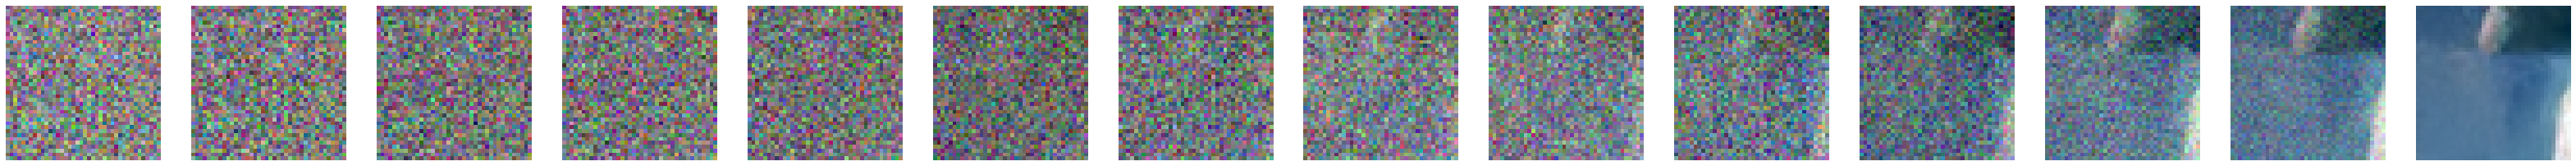

In [ ]:
# choose the size of the sample patch: 
patch_size = (C,40,40) #choose 28x28 for mnist patch size
x_c = torch.zeros(patch_size) 
if torch.cuda.is_available():
    x_c = x_c.cuda()
    # x = x.cuda()

synth = synthesis() 
sample, interm_Ys = univ_inv_sol(denoiser, 
                                 x_c = x_c, 
                                 task = synth,
                                 sig_0 = 1,
                                 sig_L = 0.01, 
                                 h0 = 0.01, 
                                 beta = 0.25,  # change beta to see how quality of generated samples change       
                                 freq = 5)

## plot the progression and the final sample
plot_synthesis(interm_Ys, sample)

# Inverse problems


Here, we use the implicit prior of the denoiser to solve linear inverse problems (i.e., recovery of an image from a partial set of linear measurements).  The same function is used to solve all problems.  In addition to the hyperparameters used in the sampling algorithm above, the linear inverse algorithm requires specification of the measurement matrix (i.e. the forward model). We provide 5 different classes: inpainting, random pixel dropping, super resolution, deblurring, and measurements on random basis (i.e. compressive sensing). You can use the algorithm for any other linear inverse problems, as long as you provide it with the forward model.

## Load a test image


In [ ]:
# Choose a test dataset
# Note: grayscale/color of the test images must be consistent with grayscale/color of denoiser training data
if grayscale is True: 
    path = 'test_images/grayscale/'
else: 
    path = 'test_images/color/'
print('Test datasets: ', os.listdir(path))

test_folder = 'Set14'



Test datasets:  ['Set5', 'Set14', 'BSD100']


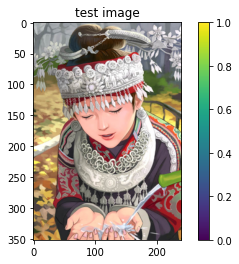

In [ ]:
# choose an image number
im_num = 1

x = test_image(grayscale, path+test_folder+'/', im_num)
x.show()

torch.Size([3, 60, 60])

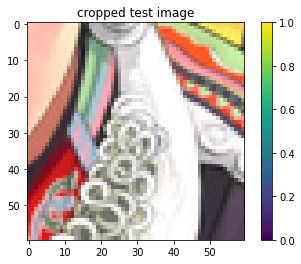

In [ ]:
# crop a portion of the image (smaller will run faster)
x = x.crop(150,150,60,60)
x.shape

## 1. Inpainting



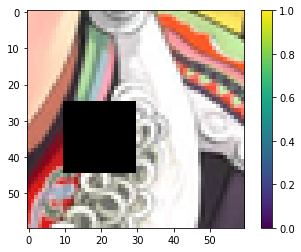

In [ ]:
# Specify top-left corner and size of "hole" to be inpainted (filled in) ***
inpaint = inpainting(x_size=x.size(), y0=20, x0=35, h=20, w=20)

plot_corrupted_im(inpaint.M(inpaint.M_T(x)))


----------------------------- 40
sigma  0.7422770857810974
----------------------------- 80
sigma  0.3241884708404541
----------------------------- 120
sigma  0.08827302604913712
----------------------------- 160
sigma  0.01387578435242176
-------- total number of iterations,  167
-------- average time per iteration (s),  0.0069


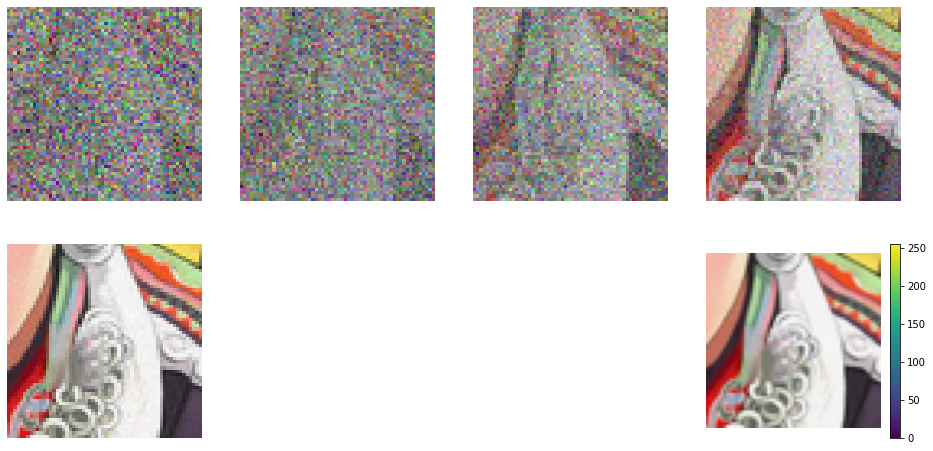

In [ ]:
# In solving linear inverse problems, in order to get good quality samples, beta should be small, that is lots of 
# added noise in each iteration. 
# This gives the algorithm the freedom to explore the space and arrive at a point on the manifold where the 
# linear constraint is satisfied

sample, interm_Ys = univ_inv_sol(denoiser, 
                                 x_c = inpaint.M_T(x), 
                                 task = inpaint,
                                 sig_0 = 1,
                                 sig_L = 0.01, 
                                 h0 = 0.01, 
                                 beta = 0.05,          
                                 freq = 40)
plot_all_samples(sample, interm_Ys)

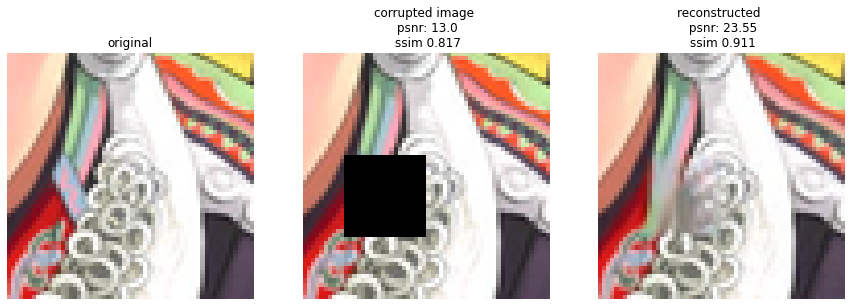

In [ ]:
plot_sample(x, inpaint.M(inpaint.M_T(x)), sample)

## 2. Missing random pixels

*** Retained 2160 / 10800 (20.0%) of dimensions
----------------------------- 40
sigma  0.5340397953987122
----------------------------- 80
sigma  0.07188498973846436
-------- total number of iterations,  97
-------- average time per iteration (s),  0.0055


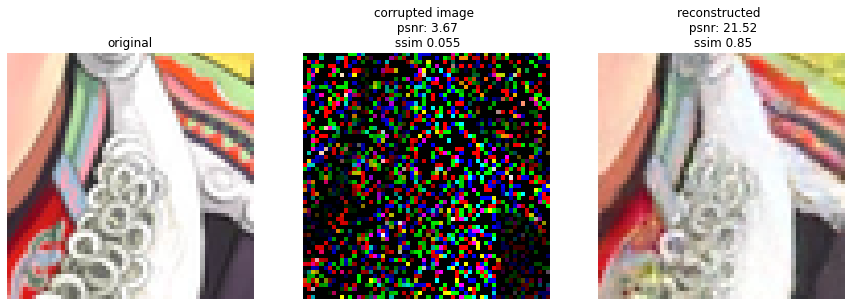

In [ ]:
# Retain a random subset of pixels. 
rand_pix = rand_pixels(x_size = x.size(), p = 0.2) # p = fraction of pixels kept

print_dim(measurment_dim=rand_pix.mask.sum().item(), image_dim=np.prod(x.shape))

sample, interm_Ys = univ_inv_sol(denoiser, 
                                 x_c = rand_pix.M_T(x), 
                                 task = rand_pix,
                                 sig_0 = 1 ,
                                 sig_L = 0.01, 
                                 h0 = 0.01, 
                                 beta = 0.1,          
                                 freq = 40)

plot_sample(x, rand_pix.M(rand_pix.M_T(x)), sample)

## 3. Super resolution 


*** Retained 10800 / 10800 (100.0%) of dimensions
----------------------------- 40
sigma  0.9224105477333069
----------------------------- 80
sigma  0.7645045518875122
----------------------------- 120
sigma  0.6190510392189026
----------------------------- 160
sigma  0.48661404848098755
----------------------------- 200
sigma  0.3690246343612671
----------------------------- 240
sigma  0.2748810648918152
----------------------------- 280
sigma  0.20993918180465698
----------------------------- 320
sigma  0.1631898432970047
----------------------------- 360
sigma  0.1222536489367485
----------------------------- 400
sigma  0.08705684542655945
----------------------------- 440
sigma  0.06297720968723297
----------------------------- 480
sigma  0.041982654482126236
----------------------------- 520
sigma  0.03057810291647911
----------------------------- 560
sigma  0.021516211330890656
----------------------------- 600
sigma  0.013982870616018772
----------------------------- 640
sigma  

/usr/local/lib/python3.7/dist-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


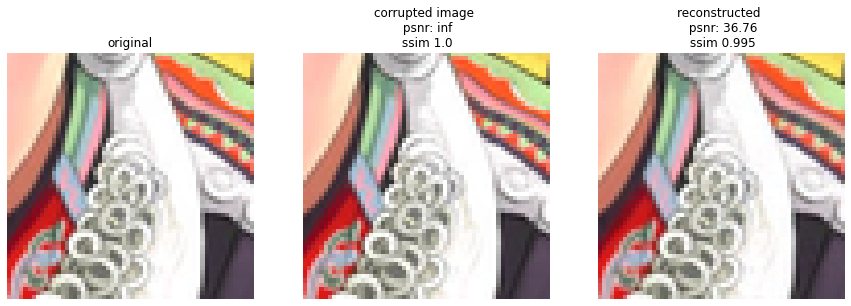

In [ ]:
# Subsample image by factor of s (both horizontally and vertially)
super_res = super_resolution(x_size=x.size(), s = 1)

print_dim(measurment_dim=np.prod(super_res.M_T(x).shape), image_dim=np.prod(x.shape))
# print_dim(measurment_dim=np.prod(super_res.M(x).shape), image_dim=np.prod(x.shape))


sample , interm_Ys = univ_inv_sol(denoiser, 
                                  x_c = super_res.M_T(x),
                                #    x_c = super_res.M(x), 

                                  task = super_res,
                                  sig_0 = 1 ,
                                  sig_L = 0.01, 
                                  h0 = 0.01, 
                                  beta = 0.01,          
                                  freq = 40)

plot_sample(x,super_res.M(super_res.M_T(x)), sample)
# plot_sample(x,super_res.M(super_res.M(x)), sample)


*** Retained 10800 / 10800 (100.0%) of dimensions
----------------------------- 40
sigma  0.516120433807373
----------------------------- 80
sigma  0.11768564581871033
----------------------------- 120
sigma  0.015854885801672935
-------- total number of iterations,  130
-------- average time per iteration (s),  0.005


/usr/local/lib/python3.7/dist-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


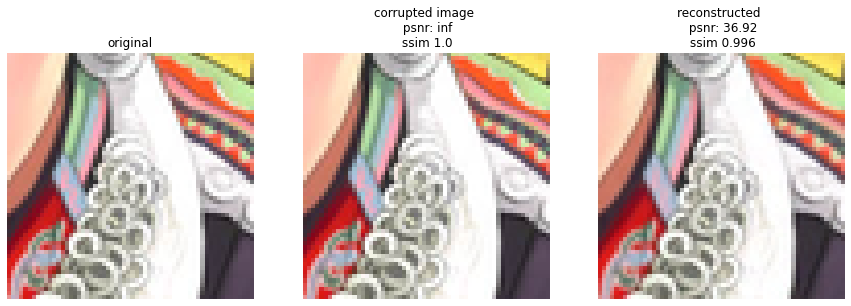

In [ ]:
# Subsample image by factor of s (both horizontally and vertially)
super_res = super_resolution(x_size=x.size(), s = 1)

# print_dim(measurment_dim=np.prod(super_res.M_T(x).shape), image_dim=np.prod(x.shape))
print_dim(measurment_dim=np.prod(super_res.M(x).shape), image_dim=np.prod(x.shape))


sample , interm_Ys = univ_inv_sol(denoiser, 
                                #   x_c = super_res.M_T(x),
                                   x_c = super_res.M(x), 

                                  task = super_res,
                                  sig_0 = 1 ,
                                  sig_L = 0.01, 
                                  h0 = 0.01, 
                                  beta = 0.1,          
                                  freq = 40)

# plot_sample(x,super_res.M(super_res.M_T(x)), sample)
plot_sample(x,super_res.M(super_res.M(x)), sample)


## 4. Random basis

*** Retained 2160 / 10800 (20.0%) of dimensions
----------------------------- 40
sigma  0.8576808571815491
----------------------------- 80
sigma  0.6526349186897278
----------------------------- 120
sigma  0.4126630425453186
----------------------------- 160
sigma  0.1905522346496582
----------------------------- 200
sigma  0.019504839554429054
-------- total number of iterations,  206
-------- average time per iteration (s),  0.0066


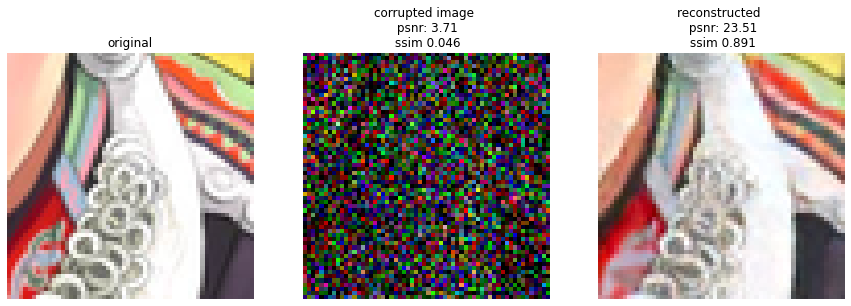

In [ ]:
# Project image onto a random set of basis functions
rand_basis = random_basis(x_size = x.shape , p = 0.2) # p = fraction of dimensions kept

print_dim(measurment_dim=rand_basis.U.shape[1], image_dim=np.prod(x.shape))

sample, interm_Ys = univ_inv_sol(denoiser, 
                                 x_c = rand_basis.M_T(x), 
                                 task = rand_basis,
                                 sig_0 = 1,
                                 sig_L = 0.01, 
                                 h0 = 0.01, 
                                 beta = .01,          
                                 freq = 40)

plot_sample(x, rand_basis.M(rand_basis.M_T(x)), sample)

## 5. Spectral super resolution

*** Retained 2028 / 10800 (18.778%) of dimensions
----------------------------- 40
sigma  0.48155730962753296
----------------------------- 80
sigma  0.04963095858693123
-------- total number of iterations,  93
-------- average time per iteration (s),  0.0049


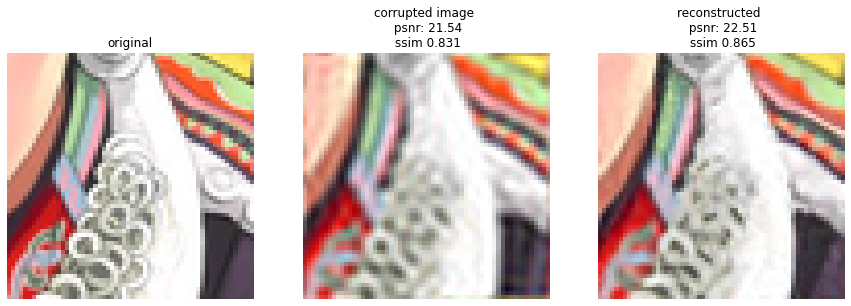

In [ ]:
# Project onto low frequencies (a subset of the Fourier basis)
spec_super_res = spectral_super_resolution(x_size= x.size(), p = 0.2) # p=fraction of low frequencies kept

print_dim(measurment_dim=spec_super_res.mask.sum()*C, image_dim=np.prod(x.shape))

sample , interm_Ys = univ_inv_sol(denoiser, 
                                  x_c=spec_super_res.M_T(x), 
                                  task = spec_super_res,
                                  sig_0=1 ,
                                  sig_L=.01, 
                                  h0=.01, 
                                  beta = 0.1,          
                                  freq = 40)

plot_sample(x, spec_super_res.M(spec_super_res.M_T(x) ), sample)